# A. Load MNIST Dataset

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import struct
import random
from array import array
from os.path import join

# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            labels = array("B", file.read())
        images = []
        with open(images_filepath, 'rb') as file:
            # read images into columns
            images = np.frombuffer(file.read(), np.uint8, offset=16).reshape(-1, 28*28).transpose()
        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)


# helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(images.shape[1] / cols) + 1
    plt.figure(figsize=(30,20))
    for i in range(images.shape[1]):
        image = images[:, i].reshape(28, 28)
        title_text = title_texts[i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)

# data files paths
training_images_filepath = './train-images.idx3-ubyte'
training_labels_filepath = './train-labels.idx1-ubyte'
test_images_filepath = './t10k-images.idx3-ubyte'
test_labels_filepath = './t10k-labels.idx1-ubyte'

# load MNSIT dataset - (images, labels)
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

**Data normalization**

In [ ]:
# A. normalize pixels color to [-0.5,0.5]
train_img = x_train / 255 - 0.5
train_labels = np.array(y_train)
test_img = x_test / 255 - 0.5
test_labels = np.array(y_test)

# B. PCA

decaying: True


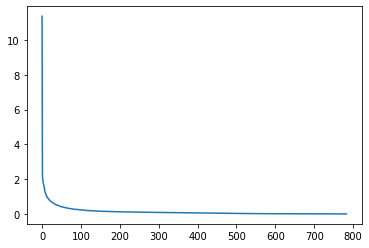

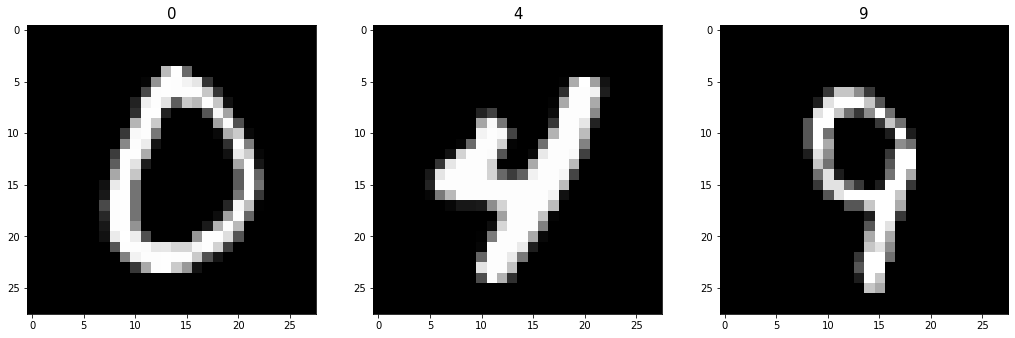

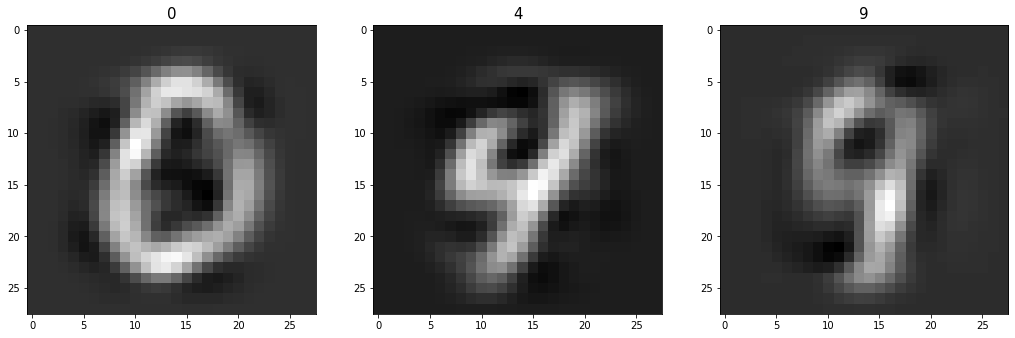

In [ ]:
# B. Do PCA on MNIST using p componenets
def pca_mnist(data, labels, p, test_plots=False):
  n, m = data.shape # n = number of pixels (28*28), m = number of images
  cov_matrix = (1/m) * (data @ data.T)
  U, S, UT = np.linalg.svd(cov_matrix)

  if test_plots:
    # plotting singular values and check they are decaying
    plt.plot(np.sqrt(S))
    print('decaying:', all(earlier >= later for earlier, later in zip(S, S[1:])))

  Up = U[:, :p]
  reduced_data = Up.T @ data
  reconstruct_data = Up @ reduced_data

  if test_plots:
    # show example samples of original VS recustructed images
    sampled_idx = random.sample(range(data.shape[1]), 3)
    sampled_labels = [labels[i] for i in sampled_idx]
    show_images((data[:, sampled_idx] + 0.5) * 255, sampled_labels)
    show_images((reconstruct_data[:, sampled_idx] + 0.5) * 255, sampled_labels)

  # return the reduced data and the principle componenets
  return reduced_data, Up

reduced_train_img, pca_components = pca_mnist(train_img, train_labels, 20, test_plots=True)

# C. K-means clustering 

In [ ]:
def find_closest_centroids(data, centroids):
  idx = np.zeros(data.shape[1])
  for i in range(data.shape[1]):
    idx[i] = np.argmin(np.sqrt(np.sum((data[:, i:i+1]-centroids) ** 2, axis=0)))
  return idx

def kmeans(data, k):
  # init centroids using random samples
  centroids = data[:, np.random.choice(data.shape[1], k, replace=False)]
  clusters = []
  prev_centroids = []
  converged = False

  # clustering until cnetroids converged
  while not converged:
    prev_centroids = centroids
    clusters = find_closest_centroids(data, centroids)
    centroids = np.column_stack([ data[:, clusters == i].mean(1, keepdims=True) for i in range(k) ])
    converged = np.array_equal(centroids, prev_centroids)
  
  return centroids, clusters

# D. Classify the reduced images

In [ ]:
# classify the reduced images to 10 clusters
k = 10
centroids, clusters = kmeans(reduced_train_img, k)

# E. Assign digits to clusters

In [ ]:
# assign a digit to each cluster according to the most frequent label in the cluster
clusters_digits = [np.argmax(np.bincount(train_labels[clusters==i])) for i in range(k)]
print(clusters_digits)

[2, 6, 7, 3, 0, 1, 8, 4, 0, 9]


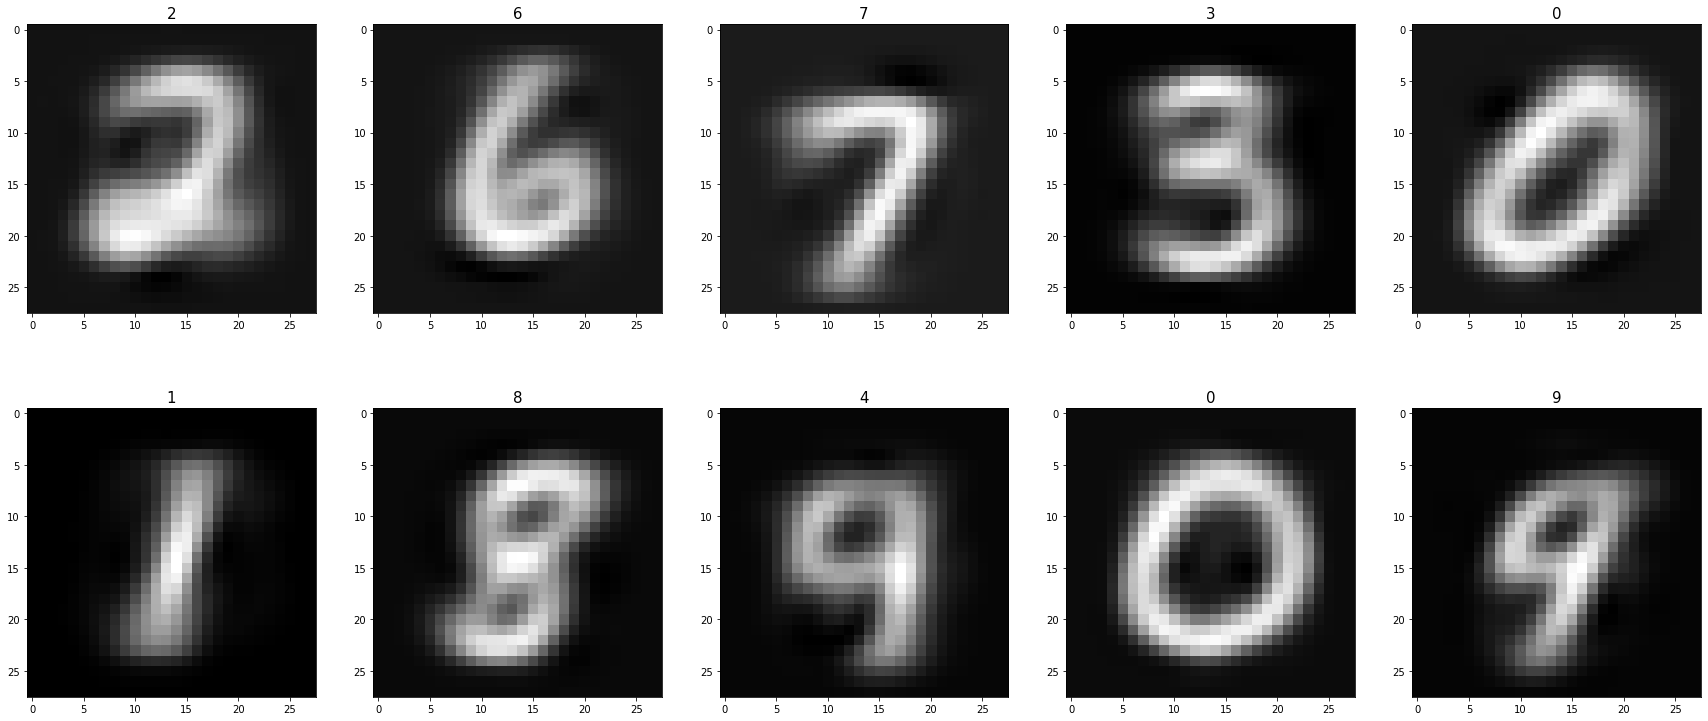

In [ ]:
# check cluster's centroids
centroids_img = pca_components @ centroids
show_images((centroids_img + 0.5) * 255, clusters_digits)


# F. Test Estimations

In [ ]:
def estimate(data, centroids, clusters_labels):
  labels = np.zeros(data.shape[1])
  for i in range(data.shape[1]):
    labels[i] = clusters_labels[np.argmin(np.sqrt(np.sum((data[:, i:i+1] - centroids) ** 2, axis=0)))]
  return labels

reduced_test_img = pca_components.T @ test_img
estimate_labels = estimate(reduced_test_img, centroids, clusters_digits)
print(estimate_labels)

total_tests = test_img.shape[1]
success = np.sum(test_labels == estimate_labels)
print('Tests: ', total_tests, 'Success: ', success, 'Rate: ', 100.0 * success / total_tests)

[7. 3. 1. ... 9. 9. 6.]
Tests:  10000 Success:  6359 Rate:  63.59


# G. Consistency Check


In [ ]:
# check results with different random clusters initiazliations
# the results are very consistent after 3 times we got ~5% difference

for i in range(3):
  centroids, clusters = kmeans(reduced_train_img, k)
  clusters_digits = [np.argmax(np.bincount(train_labels[clusters==i])) for i in range(k)]
  reduced_test_img = pca_components.T @ test_img
  estimate_labels = estimate(reduced_test_img, centroids, clusters_digits)

  total_tests = test_img.shape[1]
  success = np.sum(test_labels == estimate_labels)
  print('#Experiment', i)
  print(' Cluster digits: ', clusters_digits)
  print(' Tests: ', total_tests, 'Success: ', success, 'Rate: ', 100.0 * success / total_tests)

#Experiment 0
 Cluster digits:  [6, 4, 3, 1, 2, 9, 0, 1, 8, 7]
 Tests:  10000 Success:  5939 Rate:  59.39
#Experiment 1
 Cluster digits:  [2, 8, 3, 7, 4, 9, 1, 1, 6, 0]
 Tests:  10000 Success:  5731 Rate:  57.31
#Experiment 2
 Cluster digits:  [6, 4, 2, 0, 1, 0, 1, 3, 7, 8]
 Tests:  10000 Success:  5813 Rate:  58.13


# H. Smaller Dimensions

In [ ]:
# repeat the experiment using p=12 instead of 20
# the results are lower by only few percentage (~1-5%)

reduced_train_img, pca_components = pca_mnist(train_img, train_labels, 12)
centroids, clusters = kmeans(reduced_train_img, 10)
clusters_digits = [np.argmax(np.bincount(train_labels[clusters==i])) for i in range(k)]
reduced_test_img = pca_components.T @ test_img
estimate_labels = estimate(reduced_test_img, centroids, clusters_digits)

total_tests = test_img.shape[1]
success = np.sum(test_labels == estimate_labels)
print('Tests: ', total_tests, 'Success: ', success, 'Rate: ', 100.0 * success / total_tests)


Tests:  10000 Success:  5949 Rate:  59.49


# I. Different K-Mean Initialization

In [ ]:
def kmeans2(data, centroids, k):
  clusters = []
  prev_centroids = []
  converged = False

  # clustering until cnetroids converged
  while not converged:
    prev_centroids = centroids
    clusters = find_closest_centroids(data, centroids)
    centroids = np.column_stack([ data[:, clusters == i].mean(1, keepdims=True) for i in range(k) ])
    converged = np.array_equal(centroids, prev_centroids)
  
  return centroids, clusters


reduced_train_img, pca_components = pca_mnist(train_img, train_labels, 20)

# init each of the Kmeans centroids using the mean of 10 reduced images from each label
centroids = []
for i in range(k):
  digit_imgs = reduced_train_img[:, train_labels == i]
  centroids.append(digit_imgs[:, np.random.choice(digit_imgs.shape[1], 10, replace=False)].mean(1, keepdims=True))
centroids = np.column_stack(centroids)

centroids, clusters = kmeans2(reduced_train_img, centroids, k)
clusters_digits = [np.argmax(np.bincount(train_labels[clusters==i])) for i in range(k)]
reduced_test_img = pca_components.T @ test_img
estimate_labels = estimate(reduced_test_img, centroids, clusters_digits)
print(estimate_labels)

total_tests = test_img.shape[1]
success = np.sum(test_labels == estimate_labels)
print('Tests: ', total_tests, 'Success: ', success, 'Rate: ', 100.0 * success / total_tests)

[7. 3. 1. ... 9. 6. 6.]
Tests:  10000 Success:  6277 Rate:  62.77
